In [1]:
# Imports
import numpy as np
import os
from matplotlib import pyplot as plt
import h5py as h5
from PyXRIM.Corrections import Corrector
from PyXRIM.misc import  bin_ndarray
from functions import *
%matplotlib notebook

# Inputs

In [2]:
rawDsetName = ['S016'] # name of raw dataset
procName = ['S016_corrected'] # name of processed data
procRefName = 'bkg_corrected' # reference name to append to rawData
fname = 'D:\Libraries\Documents\Materials Informatics\LiCoO2_Al2O3_20160330.hdf5'

In [3]:
# open h5file
f = h5.File(fname, mode='r') 
# Always open in read mode 'r'.
# Until you're ready to write into the file. This is especially true if your OS is not Unix-based like Windows.
rawg = f['20160330/Raw']
procg = f['20160330/Process']
meta = f['20160330/Meta']

In [4]:
metag = f['20160330/Meta']
READ = metag['READ']
DARK = metag['DARK']

In [5]:
# Let's bin the correction files
read2x = bin_ndarray(READ[:], (2048,2048))
dark2x = bin_ndarray(DARK[:], (2048,2048))

<IPython.core.display.Javascript object>


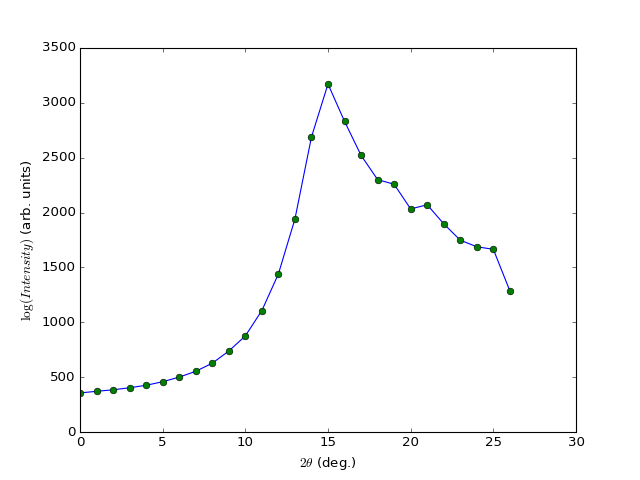

In [7]:
#normInt = normData[:].mean(axis=(1,-1))
fig,ax = plt.subplots()
#ax.plot(normInt[:],marker = 'o', markerfacecolor='r')
ax.plot(np.mean(rawg['S014'],axis=(1,-1)),marker = 'o', markerfacecolor='g')
ax.set_xlabel('$2\\theta$ (deg.)')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

In [30]:
cr = Corrector()

# Save Data Sets

<IPython.core.display.Javascript object>


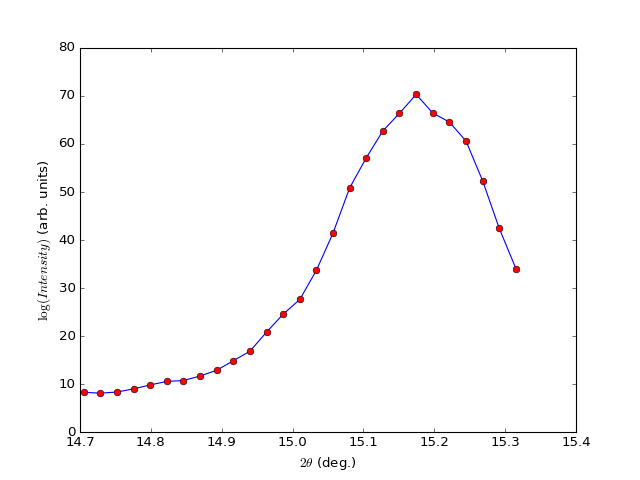

In [31]:
i = 0
for dataset in rawDsetName:
    dset = rawg[dataset]
    # Correcting for the ccd noise
    cr.loadData(dset)
    bkgData = cr.bkgSubtract(read2x,dark2x)
    # normalization
    normData = cr.normalize(monitor=None, trans = 'trans', use_processed=True)
    
    #Save the data
    procData = normData # numpy array of processed data
    f.close() # we need to close the h5file so we can open with read/write permissions
    
    # Write data into h5-file
    with h5.File(fname, 'r+') as f:
        rawg = f['20160330/Raw']
        rawDset = rawg[rawDsetName[i]]
        procg = f['20160330/Process']
        newDsetName = procName[i]
        ## NOTE: Change this to overwrite if something exists there already
        #if error, then write direct;  try accept
        
        newDset = procg.create_dataset(newDsetName, data = procData , dtype =np.float64,
                                    compression = 'lzf')
        #Write_Direct
        
        rawDset.attrs[procRefName]=newDset.ref
    
    #f.close()
    #re-open data set in read format
    f = h5.File(fname, mode='r') 
    # Always open in read mode 'r'.
    # Until you're ready to write into the file. This is especially true if your OS is not Unix-based like Windows.
    rawg = f['20160330/Raw']
    procg = f['20160330/Process']
    meta = f['20160330/Meta']
    dset = rawg[dataset]
    
    # Averaging of spatial coordinates to ensure correction was done correctly
    normInt = normData[:].mean(axis=(1,-1))
    fig,ax = plt.subplots()
    twotheta = dset.attrs['delta']
    ax.plot(twotheta,normInt[:],marker = 'o', markerfacecolor='r')
    ax.set_xlabel('$2\\theta$ (deg.)')
    ax.set_ylabel('$\log (Intensity) $ (arb. units)')
    
    i += 1  

In [5]:
f.close()